In [145]:
# first we need a bit of import boilerplate
import os
import pickle as pkl
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image
from tqdm import tqdm
from neo import SpikeTrain
import quantities as pq
import warnings
from elephant.gpfa import GPFA
from sklearn.model_selection import cross_val_score

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

output_dir = os.path.expanduser("~/ecephys/data")
resources_dir = Path.cwd().parent / 'resources'
DOWNLOAD_LFP = False


/var/folders/x1/kctky5lj58xftczlyf92pxcc0000gn/T/ipykernel_2245/981188898.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [146]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [147]:
session.get_screen_gaze_data()


,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.20620,0.072246,0.008627,3.192181,0.863288,11.996034,3.294251
3.22948,0.072116,0.008734,3.103325,0.916339,11.669031,3.496204
3.23714,0.072292,0.008807,3.116553,0.919020,11.717276,3.506406
3.27028,0.072347,0.008060,3.107700,1.061316,11.677819,4.047634
3.30396,0.072026,0.008814,3.285226,0.929605,12.331983,3.546691
...,...,...,...,...,...,...
9939.71240,NaN,NaN,NaN,NaN,NaN,NaN
9939.74576,NaN,NaN,NaN,NaN,NaN,NaN
9939.77918,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
with open('../data/processed/traj_and_pupil_data.pkl','rb') as f:
    traj_pupil_data = pkl.load(f)

traj_pupil_data

{'trajectories': array([array([[ 1.36787517,  0.87587769,  0.69618301, ..., -0.40621823,
                -0.76293471, -0.75680705],
               [ 1.19182001,  0.16587495, -0.84340428, ...,  0.3107325 ,
                -0.06493757, -0.18065655],
               [ 0.49989296,  0.86093951,  1.1917584 , ..., -0.26538589,
                -0.19455004, -0.13975237],
               ...,
               [ 0.18588842,  0.25407247,  0.32199621, ...,  0.10042668,
                 0.10323803,  0.106031  ],
               [ 0.32585712,  0.36613495,  0.39597275, ...,  0.11391229,
                 0.12175979,  0.12694887],
               [-0.65007558, -0.75955466, -0.83792719, ..., -0.34844545,
                -0.36988291, -0.36018696]])                             ,
        array([[ 1.40400812,  1.09042033,  1.63253316, ...,  0.00944795,
                -0.3561726 , -0.63975347],
               [ 0.28933225, -0.66707858, -0.84674546, ...,  0.13776242,
                -0.04609017,  0.01895273],
     

In [149]:
y = np.concatenate(traj_pupil_data["pupil area"])[:150]
X = traj_pupil_data["trajectories"][0].T

def get_model(path):
    with open(path, "rb") as f:
        return pkl.load(f)


In [150]:
xgb = get_model("../models/regression_models/initial_cv/xgb.pkl")
ridge = get_model("../models/regression_models/initial_cv/ridge.pkl")
rf = get_model("../models/regression_models/initial_cv/rf.pkl")

lstm = get_model("../models/nn_models/lstm.pkl")
lstm_rf = get_model("../models/nn_models/rf_lstm.pkl")
lstm_xgb = get_model("../models/nn_models/xgb_lstm.pkl")
lstm_ridge = get_model("../models/nn_models/ridge_lstm.pkl")

In [151]:
xgb_pred = xgb.predict(X)
ridge_pred = ridge.predict(X)
rf_pred = rf.predict(X)

xgb_pred.shape

(150,)

In [152]:
import torch

lstm_pred = lstm(torch.Tensor(X)).reshape(150).detach().numpy()
lstm_xgb_pred = lstm_xgb(torch.Tensor(xgb_pred).reshape(150,1)).reshape(150).detach().numpy()
lstm_rf_pred = lstm_xgb(torch.Tensor(rf_pred).reshape(150,1)).reshape(150).detach().numpy()
lstm_ridge_pred = lstm_xgb(torch.Tensor(ridge_pred).reshape(150,1)).reshape(150).detach().numpy()

lstm_xgb_pred.shape

(150,)

Text(0.5, 1.0, 'Regression Predictions for Pupil Area')

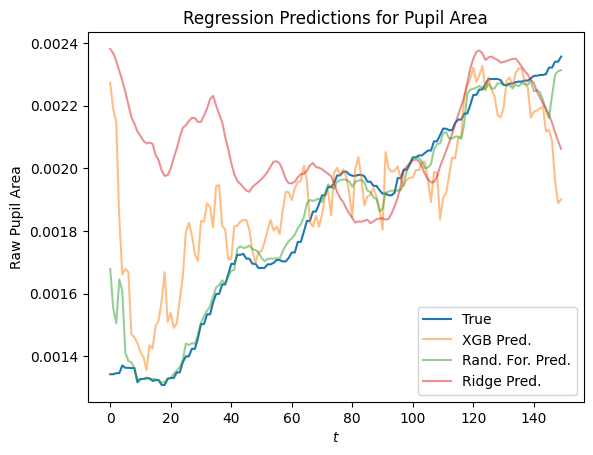

In [153]:
plt.plot(y,label='True')
plt.plot(xgb_pred,alpha=0.5,label='XGB Pred.')
plt.plot(rf_pred,alpha=0.5,label='Rand. For. Pred.')
plt.plot(ridge_pred,alpha=0.5,label='Ridge Pred.')
plt.legend()
plt.ylabel('Raw Pupil Area')
plt.xlabel('$t$')
plt.title('Regression Predictions for Pupil Area')

Text(0.5, 1.0, 'LSTM Predictions for Pupil Area')

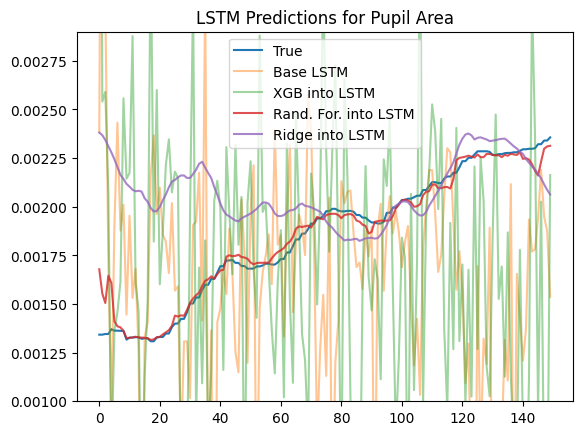

In [154]:
plt.plot(y,label='True')
plt.plot(lstm_pred,alpha=0.45,label='Base LSTM')
plt.plot(lstm_xgb_pred,alpha=0.45,label='XGB into LSTM')
plt.plot(rf_pred,alpha=0.8,label='Rand. For. into LSTM')
plt.plot(ridge_pred,alpha=.8,label='Ridge into LSTM')
plt.ylim([0.001,0.0029])
plt.legend()
plt.title('LSTM Predictions for Pupil Area')

In [155]:
stacked_pred = np.stack(
    (
        lstm_pred,
        lstm_rf_pred,
        lstm_xgb_pred,
        lstm_ridge_pred,
        rf_pred,
        xgb_pred,
        ridge_pred,
        np.arange(lstm_pred.shape[0])
    ),
    axis=1
)

with open('../models/ensemble.pkl','rb') as f:
    ens_model = pkl.load(f)

In [156]:
final_pred = ens_model.predict(stacked_pred)

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y,final_pred)

3.171750770020742e-05

Text(0.5, 1.0, 'Ensemble Prediction')

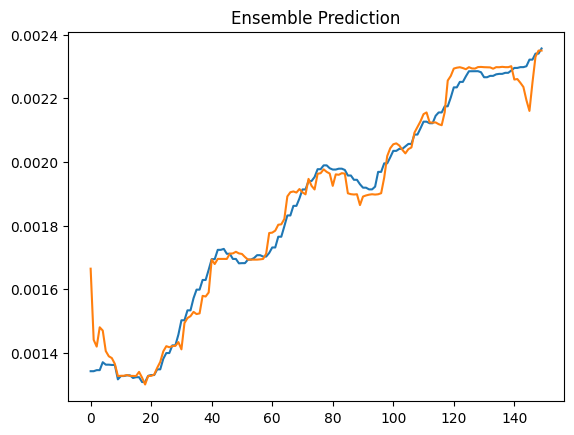

In [157]:
plt.plot(y,label='True')
plt.plot(final_pred,label='Ensemble Prediction')
plt.title('Ensemble Prediction')

In [158]:
ens_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=6, n_estimators=500)>

In [159]:
from numpy import genfromtxt

nns = ['lstm','xgb_lstm','rf_lstm','ridge_lstm']
tr_losses = [genfromtxt(f'{nn}_train_loss.csv',delimiter=',') for nn in nns]
val_losses = [genfromtxt(f'{nn}_val_loss.csv',delimiter=',') for nn in nns]

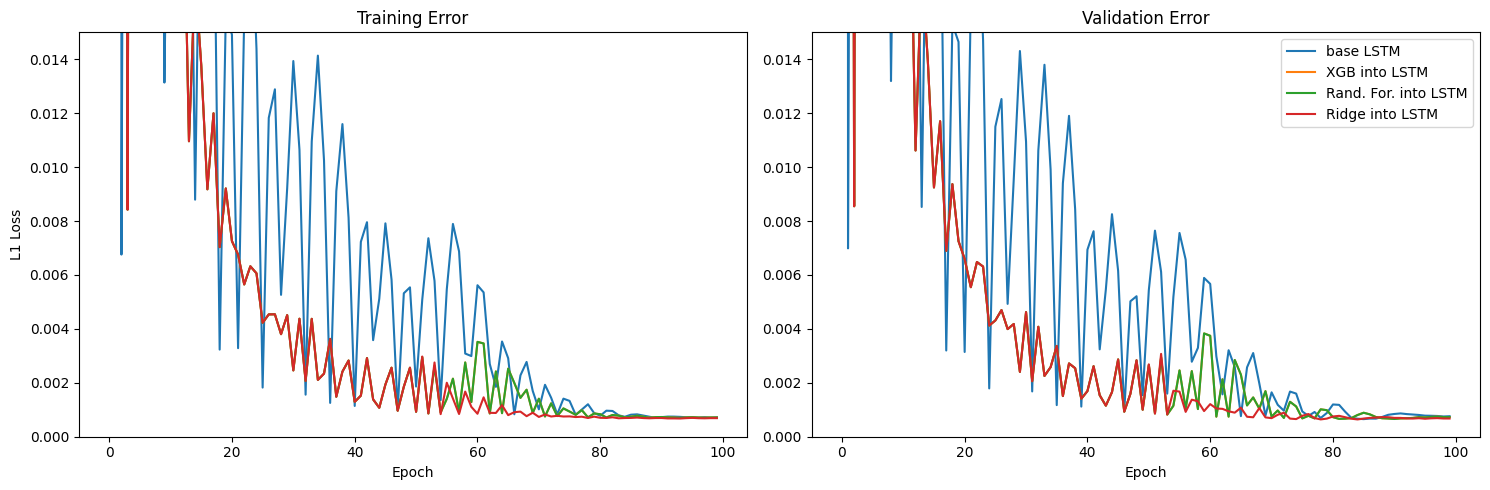

In [179]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
labels = ['base LSTM','XGB into LSTM','Rand. For. into LSTM','Ridge into LSTM']

for n,(tr_loss,val_loss) in enumerate(zip(tr_losses,val_losses)):
    ax1.plot(np.arange(100),tr_loss)
    ax2.plot(np.arange(100),val_loss,label=labels[n])
ax1.set_ylim([0,0.015])
ax2.set_ylim([0,0.015])
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('L1 Loss')
ax2.legend()
ax1.set_title('Training Error')
ax2.set_title('Validation Error')
plt.tight_layout()